# Data Preparation for Reduced order Model Prediction

This notebook processes simulation inputs and outputs for model training, focusing on feature engineering related to proximity to buildings and wind effects.


Some parts of this notebook are exploratory and were not used for the actual Machine Learning Model developed in the file Baselinemodel.ipynb. 

## Contents Overview:
### Distance Map Generation (not used in Final Model)
### Video Frame Extraction
- Loads hourly CFD result videos.
- Extracts and saves individual frames as PNG images for each hour.
- Outputs:
    - 1 PNG per hour, per simulation variable (MRT, Velocity, Air Temperature).
### Simulation Input CSV Preparation
- Processes raw CSV data for each simulation date.
- Combines wind speed, wind direction, air temperature, solar irradiation, and hour into 5-value CSVs per hour.
- Outputs:
    - One CSV per hour per date for model input.
### Wind-Aware Inverse Distance Mask (not used in Final Model)
- Computes an inverse distance map for each pixel’s proximity to buildings.
- Saves:
    - Numpy .npy and visualization .png.
### Wind-Direction Dependent Wake Masks (not used in Final Model)
- For each wind direction (0° to 359°), generates a wake mask that highlights areas downstream of buildings.
- Masks combine wind vector and inverse distance weighting.
- Saves:
    - 360 masks (1 per wind angle) as .png or .npy.

In [ ]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import imageio.v2 as iio

# 1. Distance Map

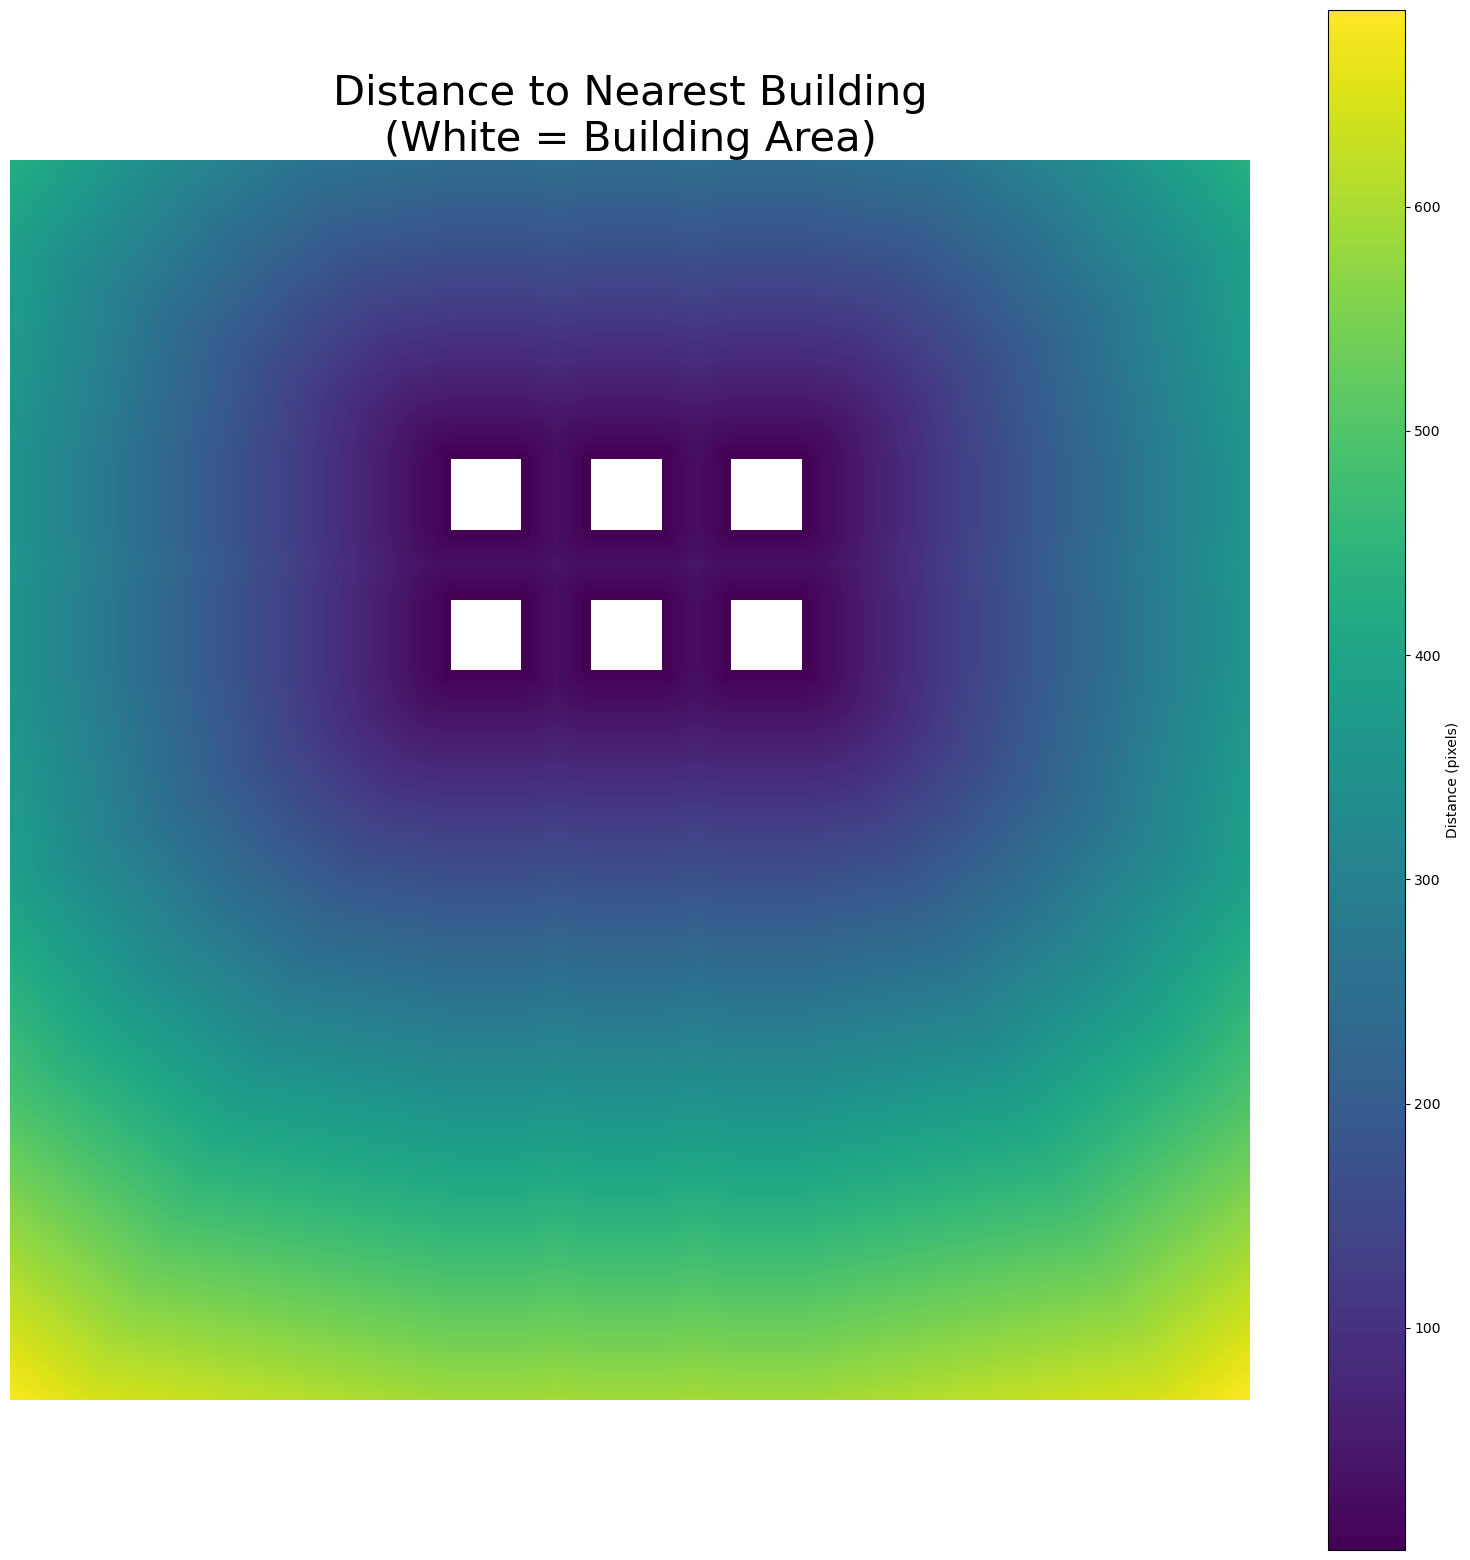

In [2]:
# ==============================
# Compute Distance to Nearest Building
# ==============================

# --- Load and preprocess building mask image ---
# Load the image as RGB and identify pure red building pixels
img = np.array(Image.open(r"..\RawSimOutputData\6Bldgs\BldgMask150cm.png").convert("RGB"))
red_mask = (img[:, :, 0] > 200) & (img[:, :, 1] < 50) & (img[:, :, 2] < 50)

# Create binary mask: 1 for non-building (background), 0 for building
non_building_mask = (~red_mask).astype(np.uint8)

# --- Compute Euclidean distance transform ---
# Calculates distance from each non-building pixel to the nearest building pixel
dist_transform = cv2.distanceTransform(non_building_mask, distanceType=cv2.DIST_L2, maskSize=5)

# --- Set distances inside buildings to NaN ---
dist_transform_nan = dist_transform.astype(float)
dist_transform_nan[red_mask] = np.nan

# --- Visualize the distance map ---
plt.figure(figsize=(20, 20))
cmap = plt.cm.viridis.copy()
cmap.set_bad(color='white')  # Buildings appear white (NaNs)

plt.imshow(dist_transform_nan, cmap=cmap)
plt.title("Distance to Nearest Building\n(White = Building Area)", fontsize=30)
plt.axis("off")
plt.colorbar(label="Distance (pixels)")
plt.show()

# 2. Video Data Processing

In [3]:
# ==============================
# Extract Frames from Simulation Videos
# ==============================

# --- Set input and output paths ---
video_folder = r"..\RawSimOutputData\6Bldgs\Videos"
output_folder = r"..\data\Y"
os.makedirs(output_folder, exist_ok=True)

# --- Get list of all .mp4 videos ---
video_files = glob(os.path.join(video_folder, "*.mp4"))

# --- Process each video ---
for video_path in video_files:
    base_name = os.path.splitext(os.path.basename(video_path))[0]

    cap = cv2.VideoCapture(video_path)
    frame_number = 1

    if not cap.isOpened():
        print(f"Failed to open video: {video_path}")
        continue

    while True:
        ret, frame = cap.read()
        if not ret:
            break  # End of video stream

        # --- Save current frame as PNG ---
        output_filename = f"{base_name}_{frame_number}.png"
        output_path = os.path.join(output_folder, output_filename)
        cv2.imwrite(output_path, frame)

        frame_number += 1

    cap.release()
    print(f"Extracted {frame_number - 1} frames from {base_name}")

print("All videos processed.")

Extracted 24 frames from 2024-03-17_6Bldgs_AT_286-293K
Extracted 24 frames from 2024-03-17_6Bldgs_MagVel_0-4ms
Extracted 24 frames from 2024-03-17_6Bldgs_MRT_286-296K
Extracted 24 frames from 2024-03-24_6Bldgs_AT_284-290K
Extracted 24 frames from 2024-03-24_6Bldgs_MagVel_0-3ms
Extracted 24 frames from 2024-03-24_6Bldgs_MRT_285-291K
Extracted 24 frames from 2024-04-01_6Bldgs_AT_282-294K
Extracted 24 frames from 2024-04-01_6Bldgs_MagVel_0-4ms
Extracted 24 frames from 2024-04-01_6Bldgs_MRT_290-302K
Extracted 24 frames from 2024-04-12_6Bldgs_AT_286-298K
Extracted 24 frames from 2024-04-12_6Bldgs_MagVel_0-3ms
Extracted 24 frames from 2024-04-12_6Bldgs_MRT_287-306K
Extracted 24 frames from 2024-04-23_6Bldgs_AT_280-291K
Extracted 24 frames from 2024-04-23_6Bldgs_MagVel_0-3ms
Extracted 24 frames from 2024-04-23_6Bldgs_MRT_285-302K
Extracted 24 frames from 2024-05-24_6Bldgs_AT_288-296K
Extracted 24 frames from 2024-05-24_6Bldgs_MagVel_0-3ms
Extracted 24 frames from 2024-05-24_6Bldgs_MRT_294-310

# 3. Sim Input Data for each Timestep

5values Winddir, speed, air temp, solar rad, hour

In [4]:
# ==============================
# Generate Hourly CSV Input Files from Simulation Data
# ==============================

# --- Set paths for input and output ---
csv_folder = "../SimulationInputs/FinalSimulationInputs"
output_folder = os.path.abspath(os.path.join(csv_folder, "../../data/X"))
os.makedirs(output_folder, exist_ok=True)

# --- Extract all unique dates from CSV filenames ---
csv_files = glob(os.path.join(csv_folder, "*.csv"))
dates = sorted(set(os.path.basename(f).split("_")[0] for f in csv_files))

# --- Process each date to create hourly input files ---
for date in dates:
    try:
        print(f"Processing {date}...")

        # --- Load hourly data for wind direction, speed, solar irradiance, and temperature ---
        wind_dir = pd.read_csv(os.path.join(csv_folder, f"{date}_wind_direction_hourly.csv"))
        wind_dir = wind_dir["Wind Direction (deg)"].reset_index(drop=True)

        wind_speed = pd.read_csv(os.path.join(csv_folder, f"{date}_wind_speed_hourly.csv"), skiprows=3)
        solar = pd.read_csv(os.path.join(csv_folder, f"{date}_solar_irradiance_hourly.csv"), skiprows=3)
        temp = pd.read_csv(os.path.join(csv_folder, f"{date}_temperature_hourly.csv"), skiprows=3)

        # --- Basic validation for expected number of rows ---
        assert len(wind_dir) >= 24, f"{date} wind direction too short"
        assert len(wind_speed) >= 25, f"{date} wind speed too short"
        assert len(solar) >= 25, f"{date} solar irradiance too short"
        assert len(temp) >= 25, f"{date} temperature too short"

        # --- Create and save hourly CSVs for the date ---
        for i in range(1, 25):  # Hours 1 to 24
            hour_str = f"{i:02d}"

            wind_speed_val = float(wind_speed["windspeed"].iloc[i])
            solar_val = float(solar["irradiation"].iloc[i])
            temp_val = float(temp["temperature"].iloc[i])

            # Use last available wind direction for hour 24 if necessary
            wind_dir_val = float(wind_dir.iloc[i]) if i < 24 else float(wind_dir.iloc[23])

            # Assemble row and save as CSV
            df = pd.DataFrame([{
                "Hour": i,
                "Windspeed (m/s)": wind_speed_val,
                "Wind Direction (deg)": wind_dir_val,
                "Solar Irradiance (W/m2)": solar_val,
                "Air Temperature (K)": temp_val,
            }])

            filename = f"5values_{date}_{hour_str}.csv"
            df.to_csv(os.path.join(output_folder, filename), index=False)

        print(f"Saved 24 hourly CSVs for {date}")

    except Exception as e:
        print(f"Failed to process {date}: {e}")

print("All input files processed.")

Processing 2024-03-17...
Saved 24 hourly CSVs for 2024-03-17
Processing 2024-03-24...
Saved 24 hourly CSVs for 2024-03-24
Processing 2024-04-01...
Saved 24 hourly CSVs for 2024-04-01
Processing 2024-04-12...
Saved 24 hourly CSVs for 2024-04-12
Processing 2024-04-23...
Saved 24 hourly CSVs for 2024-04-23
Processing 2024-05-24...
Saved 24 hourly CSVs for 2024-05-24
Processing 2024-05-29...
Saved 24 hourly CSVs for 2024-05-29
Processing 2024-06-08...
Saved 24 hourly CSVs for 2024-06-08
Processing 2024-06-10...
Saved 24 hourly CSVs for 2024-06-10
Processing 2024-06-21...
Saved 24 hourly CSVs for 2024-06-21
Processing 2024-07-20...
Saved 24 hourly CSVs for 2024-07-20
Processing 2024-07-31...
Saved 24 hourly CSVs for 2024-07-31
All input files processed.


# Winddirection mask

each pixel is weighted by wind_direction_vector X inverse_distance.

idea is to weight each pixel’s proximity to buildings by wind direction, to give the model a sense of upstream vs downstream

- Pixels behind buildings (relative to wind) are highlighted.


Inverse distance mask saved to C:\Users\Citylab\Documents\PythonProjects\ROM_UPC\data\X\DistanceMask
360 wake masks written to C:\Users\Citylab\Documents\PythonProjects\ROM_UPC\data\X\WindMask


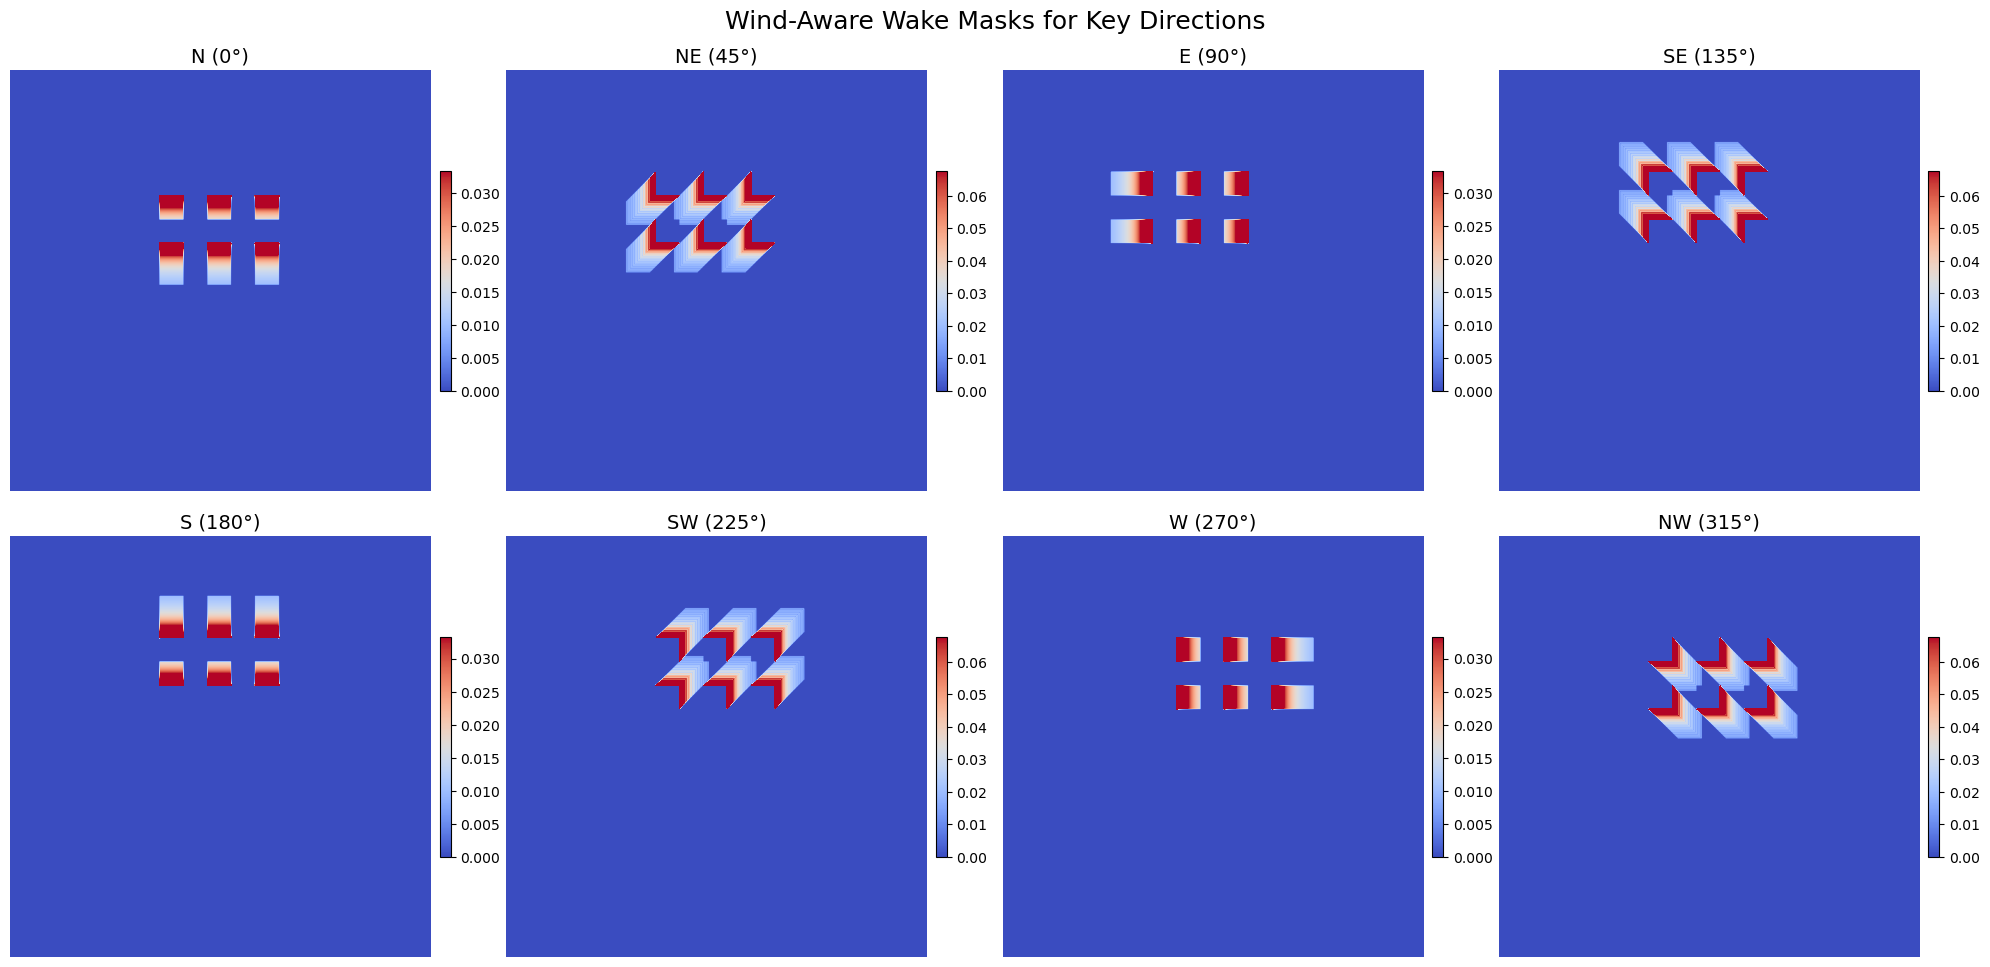

In [5]:
# ==============================
# 1. Load and Preprocess Binary Building Mask
# ==============================

# Load grayscale version of the building mask
mask_path = r"..\RawSimOutputData\6Bldgs\BldgMask150cm-BlackWhiteWithAntiAlias.png"
img_gray = np.array(Image.open(mask_path).convert("L"))

# Create binary masks for background (1) and buildings (0)
bg_mask = (img_gray > 128).astype(np.uint8)
building_mask = ~bg_mask.astype(bool)

# ==============================
# 2. Compute and Save Inverse Distance Mask
# ==============================

# Compute distance transform from background to buildings
dist = cv2.distanceTransform(bg_mask, cv2.DIST_L2, 5)
inv_dist = 1.0 / (dist + 1e-6)
inv_dist[building_mask] = 0  # Keep buildings at zero distance

# Save inverse distance mask for training use
distance_mask_dir = Path("../data/X/DistanceMask")
distance_mask_dir.mkdir(parents=True, exist_ok=True)
np.save(distance_mask_dir / "inverse_distance_mask.npy", inv_dist)

# Optional: save as PNG for visualization
inv_dist_norm = np.asarray(255 * inv_dist / (np.nanmax(inv_dist) + 1e-9), dtype=np.uint8)
iio.imwrite(distance_mask_dir / "inverse_distance_mask.png", inv_dist_norm)

print(f"Inverse distance mask saved to {distance_mask_dir.resolve()}")

# ==============================
# 3. Wind-Aware Wake Mask Generator
# ==============================

def wake_mask(angle_deg, bmask, max_len=100):
    """
    Compute wind-directional wake mask based on building layout.
    angle_deg: wind direction (0° from North, 90° from East).
    Returns inverse-distance wake map where buildings remain zero.
    """
    θ = np.deg2rad(angle_deg)
    vx = -np.sin(θ)  # X-component of wind vector (image coordinates)
    vy =  np.cos(θ)  # Y-component of wind vector

    h, w = bmask.shape
    wake_map = np.zeros((h, w), dtype=float)

    by, bx = np.where(bmask)
    for y0, x0 in zip(by, bx):
        for d in range(1, max_len):
            x = int(round(x0 + d * vx))
            y = int(round(y0 + d * vy))
            if 0 <= x < w and 0 <= y < h and not bmask[y, x]:
                wake_map[y, x] += 1.0 / (d + 1e-3)
            else:
                break

    wake_map[bmask] = 0
    return wake_map

# ==============================
# 4. Generate Wake Masks for All 360° Wind Directions
# ==============================

out_dir = Path("../data/X/WindMask")
out_dir.mkdir(parents=True, exist_ok=True)
SAVE_AS_PNG = True  # Save as PNG for compact visualization

for angle in range(360):
    wake = wake_mask(angle, building_mask, max_len=100)
    if SAVE_AS_PNG:
        w_norm = np.asarray(255 * wake / (wake.max() + 1e-9), dtype=np.uint8)
        outfile = out_dir / f"windmask_{angle:03d}.png"
        iio.imwrite(outfile, w_norm)
    else:
        outfile = out_dir / f"windmask_{angle:03d}.npy"
        np.save(outfile, wake)

print(f"360 wake masks written to {out_dir.resolve()}")

# ==============================
# 5. Visualize Example Wake Masks for Key Directions
# ==============================

angles = [0, 45, 90, 135, 180, 225, 270, 315]
labels = ["N (0°)", "NE (45°)", "E (90°)", "SE (135°)",
          "S (180°)", "SW (225°)", "W (270°)", "NW (315°)"]

fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for idx, (a, lab) in enumerate(zip(angles, labels)):
    wake = wake_mask(a, building_mask)
    ax = axs[idx // 4, idx % 4]
    vmax = np.percentile(wake, 99) or 1e-6
    im = ax.imshow(wake, cmap="coolwarm", vmin=0, vmax=vmax)
    ax.set_title(lab, fontsize=14)
    ax.axis("off")
    plt.colorbar(im, ax=ax, fraction=0.025, pad=0.02)

plt.suptitle("Wind-Aware Wake Masks for Key Directions", fontsize=18)
plt.tight_layout()
plt.show()